0 20
1 49
2 86
3 129
4 178
5 233
6 293
7 358
8 428
9 503
10 582
11 665
12 752
13 843
14 938


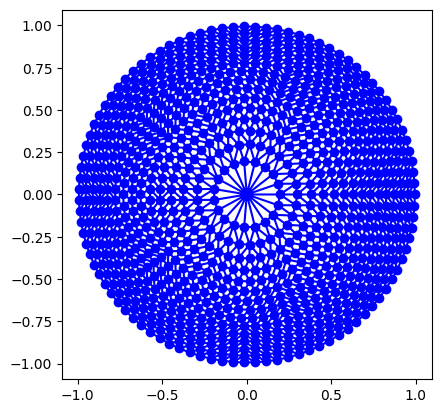

In [24]:
import trimesh
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import scipy.spatial as spatial
# distribute random points inside unit disc

rings = 15
border = 0.99
dist = (border - 0.0) / rings

points = []
points.append([0, 0])
for r_i, r in enumerate(
    (np.linspace(0.0, border, rings + 1, endpoint=True)[1:]) ** (0.6)
):
    amount = int(np.ceil(r * 2 * np.pi / dist))
    # amount = 6
    for angle in np.linspace(0, 2 * np.pi, amount, endpoint=False):
        points.append([r * np.cos(angle), r * np.sin(angle)])
    print(r_i, len(points))

points = np.array(points)
# triangulate the points
delaunay = spatial.Delaunay(points)

triang = mtri.Triangulation(
    [p[0] for p in points], [p[1] for p in points], delaunay.simplices
)
# plot the triangulation
plt.figure()

plt.gca().set_aspect("equal")
plt.triplot(triang, "bo-")
plt.show()


# create a mesh from the triangulation
mesh = trimesh.Trimesh(vertices=points, faces=triang.triangles)


# save as obj
mesh.export("../../meshes/small-disc.obj");

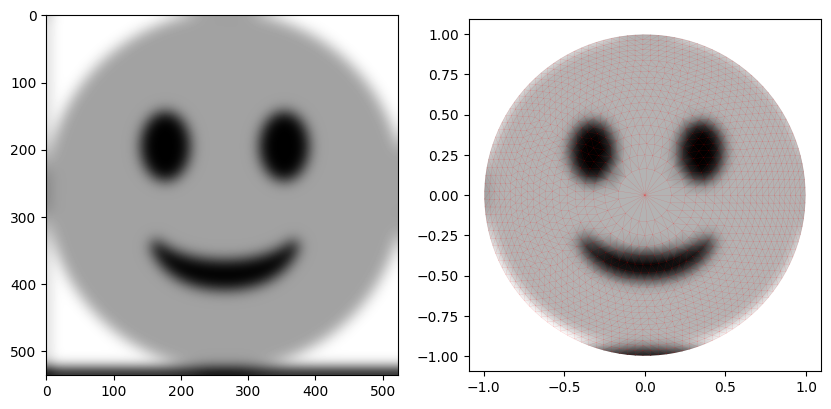

In [22]:
# load smiley.png with numpy
image = plt.imread("../../smiley2.png")
# make grayscale
image = image.mean(axis=2)
# blur image
import scipy.ndimage

image = scipy.ndimage.gaussian_filter(image, 10)
width = image.shape[1]
height = image.shape[0]

import DECMesh as dm

mesh = dm.Mesh.from_obj("../../meshes/small-disc.obj")

# get all barycenters:
barycenters = np.mean(mesh.vertices[:, [0, 2]][triang.triangles], axis=1)
barycenters = mesh.vertices[:, [0, 2]]

# get interpolated color at each vertex
colors = scipy.ndimage.map_coordinates(
    image,
    [
        height - height * (barycenters[:, 1] / 2 + 0.5),
        width * (barycenters[:, 0] / 2 + 0.5),
    ],
    order=1,
    mode="nearest",
)

edge_values = mesh.d0 @ colors

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_aspect("equal")
ax[1].set_aspect("equal")
ax[1].tripcolor(triang, colors, cmap="gray", shading="gouraud")
# plot mesh
ax[1].triplot(triang, "r-", lw=0.1, alpha=0.5)

ax[0].imshow(image, cmap="gray")
plt.show()